In [54]:
import pandas as pd
import numpy as np
import yaml
from astropy.io import fits
from pixell import enmap,utils, reproject, enplot
import matplotlib.pyplot as plt


In [44]:
def s18dStack(ras, decs, data, width = 20., weight = False, normalize = False):
        stack = 0
        divisor = 0
        num = 0
        
        rms = fits.open('/project/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')
        
        tileNames = []
        rms_names = []
        for i in range(len(ras)):
            tileNames.append(str(tileFinder(ras[i], decs[i],s18d)))
        for i in range(1,281):
            rms_names.append(str(rms[i].header['EXTNAME']))
        tileIndex = []
        for i in range(len(tileNames)):
            if tileNames[i] is None:
                tileIndex.append(None)
            else:
                #print(np.where(np.array(rms_names) == str(tileNames[i]))[0][0])
                tileIndex.append(np.where(np.array(rms_names) == str(tileNames[i]))[0][0])
                
                #IF you break this, uncomment me
                #tileIndex.append(np.where(np.array(rms_names) == str(tileNames[i]))[0][0])

        for i in range(len(ras)):
                path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'
                tileName = tileNames[i]
                
                if tileName is None: continue
                    
                tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
                stamp = reproject.postage_stamp(tile, ras[i], decs[i], width, 0.5)
                if normalize:
                    stamp[0] = stamp[0]/np.amax(stamp[0])
                if weight:
                    
                    index = tileIndex[i]
                    
                    rmsmap = rms[index].data
                    #print(ras[i], decs[i])

                    coords = np.deg2rad(np.array((decs[i],ras[i])))
                    ypix,xpix = enmap.sky2pix(tile.shape,tile.wcs,coords)

                    weight = rmsmap[int(ypix),int(xpix)]**2
                    #print(rmsmap[int(ypix),int(xpix)])
                    
                    if weight < 10**-20:
                        #print(i)
                        continue
                    
                    try: 
                        stack += stamp[0]/weight
                    except:
                        print(tileName)
                        print(tile)
                        print(stamp)
                    num += 1
                    divisor += 1/weight

                else:
                    try: 
                        stack += stamp[0]
                    except:
                        print(tileName)
                        print(tile)
                        print(stamp)

                    divisor += 1
                    num += 1

        
        try:
            stack /= divisor
        except: 
            print("Error: no items in stack")
            return None, None
        #print("Number in stack: {}".format(num))
        return stack, num

In [46]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0] >= box[1]:
            if (360 >= ra >= box[0] or 0 <= ra <box[1]) and box[2]<=dec<= box[3]:
                return tile['tileName']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None

In [71]:
with open('/project/r/rbond/jorlo/S18d_202006/selFn/tileDefinitions.yml') as f:
    
    s18d = yaml.load(f)

path = '/project/r/rbond/jorlo/HSC_data/'

WIDE = pd.read_csv(path + 'pcl_candidates_gdrop_WIDE.csv')
UDD = pd.read_csv(path + 'pcl_candidates_gdrop_UD-D.csv')

WIDE = WIDE[WIDE["fake"] == 'No']
UDD = UDD[UDD["fake"] == 'No']

HSCPCL_raw = np.loadtxt(path + 'hscpcl_z4_10arcmin_no_camira_z0.0_z0.5.txt')
HSCPCL = pd.DataFrame(data = HSCPCL_raw,  columns = ["ra", "dec"])

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


Initial cluster count: 216
Number in ACT footprint: 191


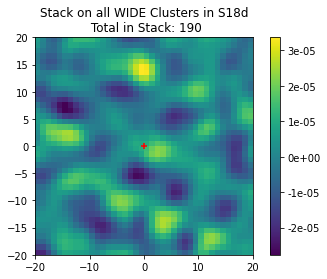

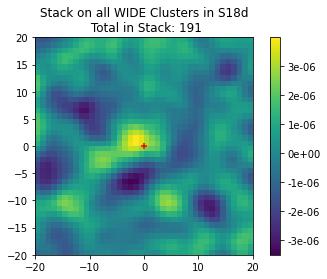

In [82]:
wide_ra = WIDE['ra'].to_numpy()
wide_dec = WIDE['dec'].to_numpy()

print('Initial cluster count: {}'.format(len(wide_ra)))

flags = [False]*len(wide_ra)


for i in range(len(wide_ra)):
    if tileFinder(wide_ra[i], wide_dec[i], s18d) is None:
        continue
    flags[i] = True

wide_ra = wide_ra[flags]
wide_dec = wide_dec[flags]

print("Number in ACT footprint: {}".format(len(wide_ra)))

s18d_stack, stack_num = s18dStack(wide_ra, wide_dec, s18d, weight = True)

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("Stack on all WIDE Clusters in S18d\n Total in Stack: {}".format(stack_num))
plt.savefig("./plots/WIDE_stack_s18d_y.png")
plt.show()
plt.close()

s18d_stack, stack_num = s18dStack(wide_ra, wide_dec, s18d, weight = False)

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("Stack on all WIDE Clusters in S18d\n Total in Stack: {}".format(stack_num))
#plt.savefig("./plots/WIDE_stack_s18d_y.png")
plt.show()
plt.close()

Initial cluster count: 44
Number in ACT footprint: 40


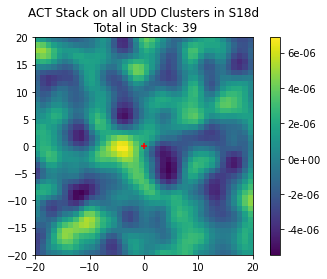

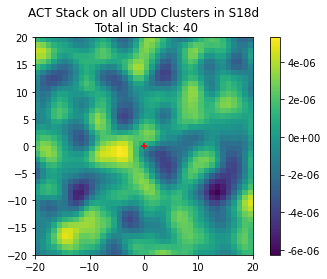

In [81]:
udd_ra = UDD['ra'].to_numpy()
udd_dec = UDD['dec'].to_numpy()

print('Initial cluster count: {}'.format(len(udd_ra)))

flags = [False]*len(udd_ra)


for i in range(len(udd_ra)):
    if tileFinder(udd_ra[i], udd_dec[i], s18d) is None:
        continue
    flags[i] = True

udd_ra = udd_ra[flags]
udd_dec = udd_dec[flags]

print("Number in ACT footprint: {}".format(len(udd_ra)))

s18d_stack, stack_num = s18dStack(udd_ra, udd_dec, s18d, weight = True)

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("ACT Stack on all UDD Clusters in S18d\n Total in Stack: {}".format(stack_num))
plt.savefig("./plots/UDD_stack_s18d_y.png")
plt.show()
plt.close()

s18d_stack, stack_num = s18dStack(udd_ra, udd_dec, s18d)

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("ACT Stack on all UDD Clusters in S18d\n Total in Stack: {}".format(stack_num))
#plt.savefig("./plots/UDD_stack_s18d_y.png")
plt.show()
plt.close()

Initial cluster count: 105
Number in ACT footprint: 85


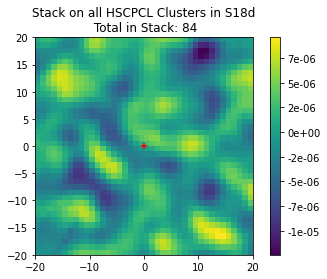

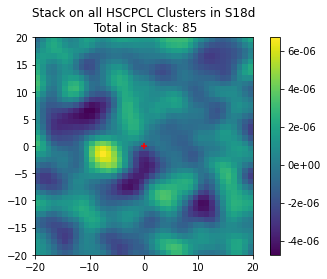

In [80]:
hscpcl_ra = HSCPCL['ra'].to_numpy()
hscpcl_dec = HSCPCL['dec'].to_numpy()

print('Initial cluster count: {}'.format(len(hscpcl_ra)))

flags = [False]*len(hscpcl_ra)


for i in range(len(hscpcl_ra)):
    if tileFinder(hscpcl_ra[i], hscpcl_dec[i], s18d) is None:
        continue
    flags[i] = True

hscpcl_ra = hscpcl_ra[flags]
hscpcl_dec = hscpcl_dec[flags]

print("Number in ACT footprint: {}".format(len(hscpcl_ra)))

s18d_stack, stack_num = s18dStack(hscpcl_ra, hscpcl_dec, s18d, weight = True)

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("Stack on all HSCPCL Clusters in S18d\n Total in Stack: {}".format(stack_num))
plt.savefig("./plots/HSCPCL_stack_s18d_y.png")
plt.show()
plt.close()

s18d_stack, stack_num = s18dStack(hscpcl_ra, hscpcl_dec, s18d)

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("Stack on all HSCPCL Clusters in S18d\n Total in Stack: {}".format(stack_num))
#plt.savefig("./plots/HSCPCL_stack_s18d_y.png")
plt.show()
plt.close()